In [88]:

import numpy as np 
import pandas as pd
import io
import os
import warnings
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.feature_selection import SelectPercentile, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate, cross_val_score, RepeatedStratifiedKFold,\
StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve, confusion_matrix, recall_score, precision_score
from sklearn.exceptions import ConvergenceWarning
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy import stats
from scipy.stats import chi2_contingency
from datetime import datetime, date
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
sba = pd.read_csv('C:/Users/SACHIN/Desktop/SBAnational.csv')
sba.head()

C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\232264604.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sba = pd.read_csv('C:/Users/SACHIN/Desktop/SBAnational.csv')


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [10]:
sba.shape

(899164, 27)

In [11]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    nan = []

    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
        nan.append(df[i].isna().sum()/len(df)*100)

    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques, 'nan%': nan})

report(sba)

,Column,d_type,unique_sample,n_uniques,nan%
0,LoanNr_ChkDgt,int64,"[1000014003, 1000024006, 1000034009, 100004400...",899164,0.000000
1,Name,object,"[ABC HOBBYCRAFT, LANDMARK BAR & GRILLE (THE), ...",779583,0.001557
2,City,object,"[EVANSVILLE, NEW PARIS, BLOOMINGTON, BROKEN AR...",32581,0.003336
3,State,object,"[IN, OK, FL, CT, NJ]",51,0.001557
4,Zip,int64,"[47711, 46526, 47401, 74012, 32801]",33611,0.000000
5,Bank,object,"[FIFTH THIRD BANK, 1ST SOURCE BANK, GRANT COUN...",5802,0.173383
6,BankState,object,"[OH, IN, OK, FL, DE]",56,0.174162
7,NAICS,int64,"[451120, 722410, 621210, 0, 332721]",1312,0.000000
8,ApprovalDate,object,"[28-Feb-97, 2-Jun-80, 7-Feb-06, 11-Jun-80, 4-O...",9859,0.000000
9,ApprovalFY,object,"[1997, 1980, 2006, 1998, 1999]",70,0.000000


In [12]:
print(f'Object columns: {len(sba.select_dtypes(include="object").columns)}')
print(f'Numeric columns: {len(sba.select_dtypes(exclude="object").columns)}')

Object columns: 17
Numeric columns: 10


# Data Cleansing and Preprocessing

## ChgOffDate

In [13]:
# drop ChgOffDate because it has to many nan values
sba.drop('ChgOffDate', axis=1, inplace=True)

## State

In [14]:
# focus on top 5 states only (California, Texas, New York, Florida, 'Pennsylvania')
top_5_state = sba['State'].value_counts(normalize=True).sort_values(ascending=False).head().index
sba5 = sba[sba['State']=='CA']
sba5['State'].unique()

array(['CA'], dtype=object)

In [15]:
sba5.drop('State', axis=1, inplace=True)

C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\2029635731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5.drop('State', axis=1, inplace=True)


## MIS_Status

In [16]:
sba5['MIS_Status'].isna().sum()

131

In [17]:
sba5.dropna(subset='MIS_Status', inplace=True)
sba5['MIS_Status'].isna().sum()

C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\121262954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5.dropna(subset='MIS_Status', inplace=True)


0

In [18]:
# checking MIS Status values
sba5['MIS_Status'].value_counts(normalize=True)

MIS_Status
P I F     0.814849
CHGOFF    0.185151
Name: proportion, dtype: float64

In [19]:
# changing it to integer
pd.Series(np.where(sba5['MIS_Status']=='P I F', 0, 1)).value_counts(normalize=True)

0    0.814849
1    0.185151
Name: proportion, dtype: float64

In [20]:
sba5['MIS_Status'] = np.where(sba5['MIS_Status']=='P I F', 0, 1)

C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\484464269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5['MIS_Status'] = np.where(sba5['MIS_Status']=='P I F', 0, 1)


In [21]:
# check duplicated rows based on all columns
sba5.duplicated().sum()

0

## ApprovalDate

In [22]:
# Get month of approval date and delete ApprovalDate because it's too detail information
sba5['ApprovalMonth'] = sba5['ApprovalDate'].str.split('-').str[1]
sba5.drop('ApprovalDate', axis=1, inplace=True)

C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\519008141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5['ApprovalMonth'] = sba5['ApprovalDate'].str.split('-').str[1]
C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\519008141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5.drop('ApprovalDate', axis=1, inplace=True)


## NAICS

In [23]:
# convert NAICS code into related sector
sba5['NAICS'] = sba5['NAICS'].astype('string')

naics_to_sector = {
    '11': 'Agriculture, Forestry, Fishing and Hunting',
    '21': 'Mining, Quarrying, and Oil and Gas Extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31-33': 'Manufacturing',
    '42': 'Wholesale Trade',
    '44-45': 'Retail Trade',
    '48-49': 'Transportation and Warehousing',
    '51': 'Information',
    '52': 'Finance and Insurance',
    '53': 'Real Estate and Rental and Leasing',
    '54': 'Professional, Scientific, and Technical Services',
    '55': 'Management of Companies and Enterprises',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '61': 'Educational Services',
    '62': 'Health Care and Social Assistance',
    '71': 'Arts, Entertainment, and Recreation',
    '72': 'Accommodation and Food Services',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration',
    # Add more NAICS codes and sectors as needed
}

# Function to get the sector for a given NAICS code
def get_sector(naics_code):
    # Handle cases where the code has more than 2 digits (e.g., '31-33')
    first_two = naics_code[:2]
    if first_two in ['31', '44', '48']:
        if first_two == '31':
            return naics_to_sector['31-33']
        elif first_two == '44':
            return naics_to_sector['44-45']
        else:
            return naics_to_sector['48-49']
    else:
        return naics_to_sector.get(first_two, 'Unknown Sector')
    
sba5['Sector'] = sba5['NAICS'].apply(get_sector)
sba5.drop('NAICS', axis=1, inplace=True)

C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\1523320181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5['NAICS'] = sba5['NAICS'].astype('string')
C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\1523320181.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5['Sector'] = sba5['NAICS'].apply(get_sector)
C:\Users\SACHIN\AppData\Local\Temp\ipykernel_12332\1523320181.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

## Term

In [24]:
# Process Term into group
(sba5['Term']/365).describe()

count    130488.000000
mean          0.388385
std           0.265460
min           0.000000
25%           0.210959
50%           0.263014
75%           0.657534
max           1.443836
Name: Term, dtype: float64

In [18]:
sba5['TermGroup'] = np.where(sba5['Term']<=90,'Below 3 months',
                            np.where((sba5['Term']>90) & (sba5['Term']<=180), '3-6 months',
                            np.where((sba5['Term']>180) & (sba5['Term']<=365), '6-12 months', 'More Than a Year')))
display(sba5[['Term', 'TermGroup']].sample(10))
sba5.drop('Term', axis=1, inplace=True)

/tmp/ipykernel_531/221062079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5['TermGroup'] = np.where(sba5['Term']<=90,'Below 3 months',


,Term,TermGroup
637900,84,Below 3 months
3241,84,Below 3 months
543966,300,6-12 months
64351,27,Below 3 months
745452,240,6-12 months
752060,300,6-12 months
836741,84,Below 3 months
286167,12,Below 3 months
670342,84,Below 3 months
891097,84,Below 3 months


/tmp/ipykernel_531/221062079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sba5.drop('Term', axis=1, inplace=True)


## NewExist

In [25]:
# drop NewExist when 0 and NaN
display(sba5['NewExist'].value_counts(dropna=False))
sba5 = sba5[sba5['NewExist']!=0]
sba5.dropna(subset='NewExist')['NewExist'].value_counts(dropna=False)

NewExist
1.0    108836
2.0     21529
0.0       112
NaN        11
Name: count, dtype: int64

NewExist
1.0    108836
2.0     21529
Name: count, dtype: int64

In [26]:
# drop NaN from NewExist. Will not effect that much to the model.
sba5 = sba5.dropna(subset='NewExist')

In [27]:
sba5['NewExist'] = np.where(sba5['NewExist']==1, 'Exist Business', 'New Business')

## BalanceGross

In [28]:
# drop BalanceGross it has only one value
sba5.drop('BalanceGross', axis=1, inplace=True)

## ChgOffPrinGr

In [29]:
# drop ChgOffPrinGr it will leaks information to the model.
# Everytime it has a value, the status always CHGOFF
sba5.drop('ChgOffPrinGr', axis=1, inplace=True)

## SBA_Appv

In [30]:
# drop SBA_Appv, in the future will would not know how much the amount will be approved
sba5.drop('SBA_Appv', axis=1, inplace=True)

## DisbursementGross

In [31]:
# drop DisbursementGross, we don't need it
sba5.drop('DisbursementGross', axis=1, inplace=True)

## DisbursementDate

In [32]:
# drop DisbursementDate, we don't need it
sba5.drop('DisbursementDate', axis=1, inplace=True)

## ApprovalFY

In [33]:
# We drop approvalFY besauce we want to predict future loan proposal.
# So, if we want to predict proposal from FY 2023, the model will not know the data yet.
sba5.drop('ApprovalFY', axis=1, inplace=True)

## GrAppv

In [34]:
# process GrAppv, replace $ and , with empty string
sba5['GrAppv'] = sba5['GrAppv'].str.replace('$', '')
sba5['GrAppv'] = sba5['GrAppv'].str.replace(',', '')
sba5['GrAppv'] = sba5['GrAppv'].astype('float')

## Name

In [35]:
checking_name = sba5.groupby(['Name', 'NewExist']).agg({"Name":"count", "MIS_Status":"mean"}).rename(columns={'Name':'Count', 'NewExist': 'NewExist_Ratio', 'MIS_Status':'CHGOff_Ratio'})
checking_name.sort_values('Count', ascending=False)

,,Count,CHGOff_Ratio
Name,NewExist,,
SUBWAY,Exist Business,38,0.026316
QUIZNO'S SUBS,New Business,37,0.135135
COLD STONE CREAMERY,New Business,34,0.176471
"Meathead Movers, Inc.",Exist Business,31,0.000000
QUIZNO'S CLASSIC SUBS,New Business,30,0.033333
...,...,...,...
"Flora Forte, Inc.",Exist Business,1,0.000000
Flor D Caffee Pastry,Exist Business,1,1.000000
Floors Unlimited,Exist Business,1,0.000000


In [36]:
sba5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130365 entries, 28 to 899161
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LoanNr_ChkDgt  130365 non-null  int64  
 1   Name           130365 non-null  object 
 2   City           130359 non-null  object 
 3   Zip            130365 non-null  int64  
 4   Bank           130233 non-null  object 
 5   BankState      130232 non-null  object 
 6   Term           130365 non-null  int64  
 7   NoEmp          130365 non-null  int64  
 8   NewExist       130365 non-null  object 
 9   CreateJob      130365 non-null  int64  
 10  RetainedJob    130365 non-null  int64  
 11  FranchiseCode  130365 non-null  int64  
 12  UrbanRural     130365 non-null  int64  
 13  RevLineCr      129861 non-null  object 
 14  LowDoc         130194 non-null  object 
 15  MIS_Status     130365 non-null  int32  
 16  GrAppv         130365 non-null  float64
 17  ApprovalMonth  130365 non-null  o

## RevLineCr

In [37]:
# checking RevLineCr
sba5['RevLineCr'].value_counts()

RevLineCr
N    52140
0    45653
Y    29697
T     2359
1        7
`        4
4        1
Name: count, dtype: int64

In [38]:
# We will filter only N and Y since those are only explainable value
sba5 = sba5[sba5['RevLineCr'].isin(['N','Y'])]

## LowDoc

In [39]:
# checking LowDoc
sba5['LowDoc'].value_counts()

LowDoc
N    78034
Y     3178
0      376
S       45
C       27
A        5
R        2
Name: count, dtype: int64

In [40]:
# We will filter only N and Y since those are only explainable value
sba5 = sba5[sba5['LowDoc'].isin(['N','Y'])]

## Bank, BankState, City, LowDoc

In [41]:
# We drop rows that the Bank, BankState, City and LowDoc that have Null value
sba5.dropna(subset=['Bank', 'BankState', 'City', 'LowDoc'], inplace=True)

## BankState

In [42]:
sba5['BankState'].value_counts().describe()

count       49.000000
mean      1654.571429
std       6580.169296
min          1.000000
25%          4.000000
50%         16.000000
75%        324.000000
max      44045.000000
Name: count, dtype: float64

In [43]:
# We convert BankState that appeared under 15 times into 'OTHER'
count_bankst = sba5['BankState'].value_counts().to_frame().reset_index().rename(columns={'count':'BankstCount'})
sba5 = sba5.merge(count_bankst, on='BankState', how='left')
sba5['NewBankState'] = np.where(sba5['BankstCount']>15, sba5['BankState'], 'OTHER')
sba5.drop(['BankState', 'BankstCount'], axis=1, inplace=True)

## Name, LoanNr_ChkDgt

In [44]:
sba5.drop(['Name', 'LoanNr_ChkDgt', 'Zip'], axis=1, inplace=True)

## FranchiseCode

In [45]:
sba5['IsFranchise'] = np.where(((sba5['FranchiseCode']==1) | (sba5['FranchiseCode']==0)), 'Y', 'N')
sba5.drop('FranchiseCode', axis=1, inplace=True)

In [46]:
sba5['IsFranchise'].value_counts()

IsFranchise
Y    78925
N     2149
Name: count, dtype: int64

In [47]:
sba5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81074 entries, 0 to 81073
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   City           81074 non-null  object 
 1   Bank           81074 non-null  object 
 2   Term           81074 non-null  int64  
 3   NoEmp          81074 non-null  int64  
 4   NewExist       81074 non-null  object 
 5   CreateJob      81074 non-null  int64  
 6   RetainedJob    81074 non-null  int64  
 7   UrbanRural     81074 non-null  int64  
 8   RevLineCr      81074 non-null  object 
 9   LowDoc         81074 non-null  object 
 10  MIS_Status     81074 non-null  int32  
 11  GrAppv         81074 non-null  float64
 12  ApprovalMonth  81074 non-null  object 
 13  Sector         81074 non-null  object 
 14  NewBankState   81074 non-null  object 
 15  IsFranchise    81074 non-null  object 
dtypes: float64(1), int32(1), int64(5), object(9)
memory usage: 9.6+ MB


## City

In [48]:
# City has too many unique value.
# Also, most of them (75%) are only appear once or 12 times only.
# We need to process it so it would not make the model too complex.
sba5['City'] = sba5['City'].str.upper()
sba5['City'].nunique()

1929

In [49]:
sba5['City'].value_counts().to_frame().describe()

,count
count,1929.000000
mean,42.029031
std,222.500499
min,1.000000
25%,1.000000
50%,2.000000
75%,17.000000
max,7522.000000


In [50]:
count_city = sba5['City'].value_counts().to_frame().reset_index().rename(columns={'count': 'City_Count'})

In [51]:
count_city[(count_city['City_Count']>25)&(count_city['City_Count']<=50)]

,City,City_Count
308,ORANGEVALE,50
309,NORTH HIGHLANDS,50
310,SAUSALITO,50
311,SAN ANSELMO,49
312,IRWINDALE,49
...,...,...
418,TEMPLE CITY (RUDELL),27
419,DESERT HOT SPRINGS,26
420,MONTROSE,26
421,NORTHRIDGE (NORTH LOS ANGELES),26


In [52]:
sba5 = sba5.merge(count_city, on='City')

In [53]:
sba5['NewCity'] = np.where(sba5['City_Count']>100, sba5['City'], 'OTHER')

In [54]:
checking_city = sba5.groupby('NewCity').agg({'MIS_Status':'mean'}).sort_values('MIS_Status', ascending=False).reset_index()
checking_city[checking_city['NewCity']=='OTHER']

,NewCity,MIS_Status
89,OTHER,0.206484


In [55]:
sba5.drop(['City', 'City_Count'],axis=1,inplace=True)

## Bank

In [56]:
# Bank has too many unique value.
# Also, most of them (75%) are only appear once or 29 times only.
# We need to process it so it would not make the model too complex.
sba5['Bank'] = sba5['Bank'].str.upper()
sba5['Bank'].nunique()

469

In [57]:
sba5['Bank'].value_counts().to_frame().describe()

,count
count,469.000000
mean,172.865672
std,849.322893
min,1.000000
25%,2.000000
50%,7.000000
75%,46.000000
max,12171.000000


In [58]:
count_bank = sba5['Bank'].value_counts().to_frame().reset_index().rename(columns={'count': 'Bank_Count'})

In [59]:
count_bank[(count_bank['Bank_Count']>1)&(count_bank['Bank_Count']<=29)]

,Bank,Bank_Count
141,EXCHANGE BANK,29
142,PREMIER VALLEY BANK,29
143,FIRST REPUBLIC BANK,29
144,FDIC/MECHANICS BANK,28
145,GROW AMERICA FUND INC,28
...,...,...
352,CHETCO FCU,2
353,NEW VENTURES CAP. DEVEL CO,2
354,FIRST FINANCIAL BANK,2
355,"BANK OF NEVADA, A DIVISION OF",2


In [60]:
sba5 = sba5.merge(count_bank, on='Bank')
sba5['NewBank'] = np.where(sba5['Bank_Count']>100, sba5['Bank'], 'OTHER')
checking_bank = sba5.groupby('NewBank').agg({'MIS_Status':'mean'}).sort_values('MIS_Status', ascending=False).reset_index()
checking_bank[checking_bank['NewBank']=='OTHER']

,NewBank,MIS_Status
23,OTHER,0.152302


In [61]:
sba5.drop(['Bank', 'Bank_Count'], axis=1, inplace=True)

In [62]:
sba5['MIS_Status'].value_counts()

MIS_Status
0    63604
1    17470
Name: count, dtype: int64

In [63]:
sba5['UrbanRural'] = np.where(sba5['UrbanRural']==1, 'Urban',
                             np.where(sba5['UrbanRural']==2, 'Rural', 'Undefined'))

## GrAppv

In [64]:
# we don't need to use this feature since we are needed to help banks to determine
# the company's status (CHGOFF or PIF) even before the bank approves their proposal
sba5.drop('GrAppv', axis=1, inplace=True)

# Exploratory Data Analysis and Visualization

In [65]:
sba5.rename(columns={'MIS_Status':'ChargeOff'}, inplace=True)
sba5['ChargeOff'] = sba5['ChargeOff'].astype('category')

In [66]:
sba_cat = sba5.select_dtypes(include='object')
sba_num = sba5.select_dtypes(exclude='object')

In [67]:
for col in sba_cat.columns:
    sba_cat[col] = sba_cat[col].astype('category')

In [68]:
sba_cat.columns

Index(['NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc', 'ApprovalMonth',
       'Sector', 'NewBankState', 'IsFranchise', 'NewCity', 'NewBank'],
      dtype='object')

In [69]:
sba_cat.head()

,NewExist,UrbanRural,RevLineCr,LowDoc,ApprovalMonth,Sector,NewBankState,IsFranchise,NewCity,NewBank
0,New Business,Urban,Y,N,Feb,Educational Services,SD,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC
1,Exist Business,Urban,Y,N,Aug,Retail Trade,CA,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC
2,Exist Business,Undefined,N,N,Nov,Unknown Sector,SD,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC
3,Exist Business,Undefined,N,N,Nov,Unknown Sector,CA,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC
4,Exist Business,Urban,Y,N,Jun,Health Care and Social Assistance,SD,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC


In [70]:
def cat_vs_chgoff(column):
    chgoff_ = sba5.groupby(column)['ChargeOff'].value_counts(normalize=True).to_frame()
    chgoff_.columns = ['Proportion']
    chgoff_pvt = chgoff_.reset_index().\
    pivot(columns='ChargeOff', index=column, values='Proportion')
    chgoff_pvt.fillna(0, inplace=True)
    display(chgoff_pvt*100)

    contingency = sba5.groupby([column, 'ChargeOff']).agg({'ChargeOff':'count'}).rename(columns={'ChargeOff':'Count'}).reset_index().pivot(index=column, columns='ChargeOff', values='Count')
    stat, p, dof, expected = chi2_contingency(contingency)
    if(p<0.05):
        print(f'Column {column} has strong relationship with ChargeOff.')
    else:
        print(f'Column {column} has weak relationship with ChargeOff.')

    chgoff_pvt.plot(kind='bar', stacked=True, figsize=(16,10))
    plt.title(f'Charge Off proportion by {column}')
    plt.show()
    print('------------------------------------------------------------------------------')

ChargeOff,0,1
NewExist,,
Exist Business,79.145718,20.854282
New Business,74.900008,25.099992


Column NewExist has strong relationship with ChargeOff.


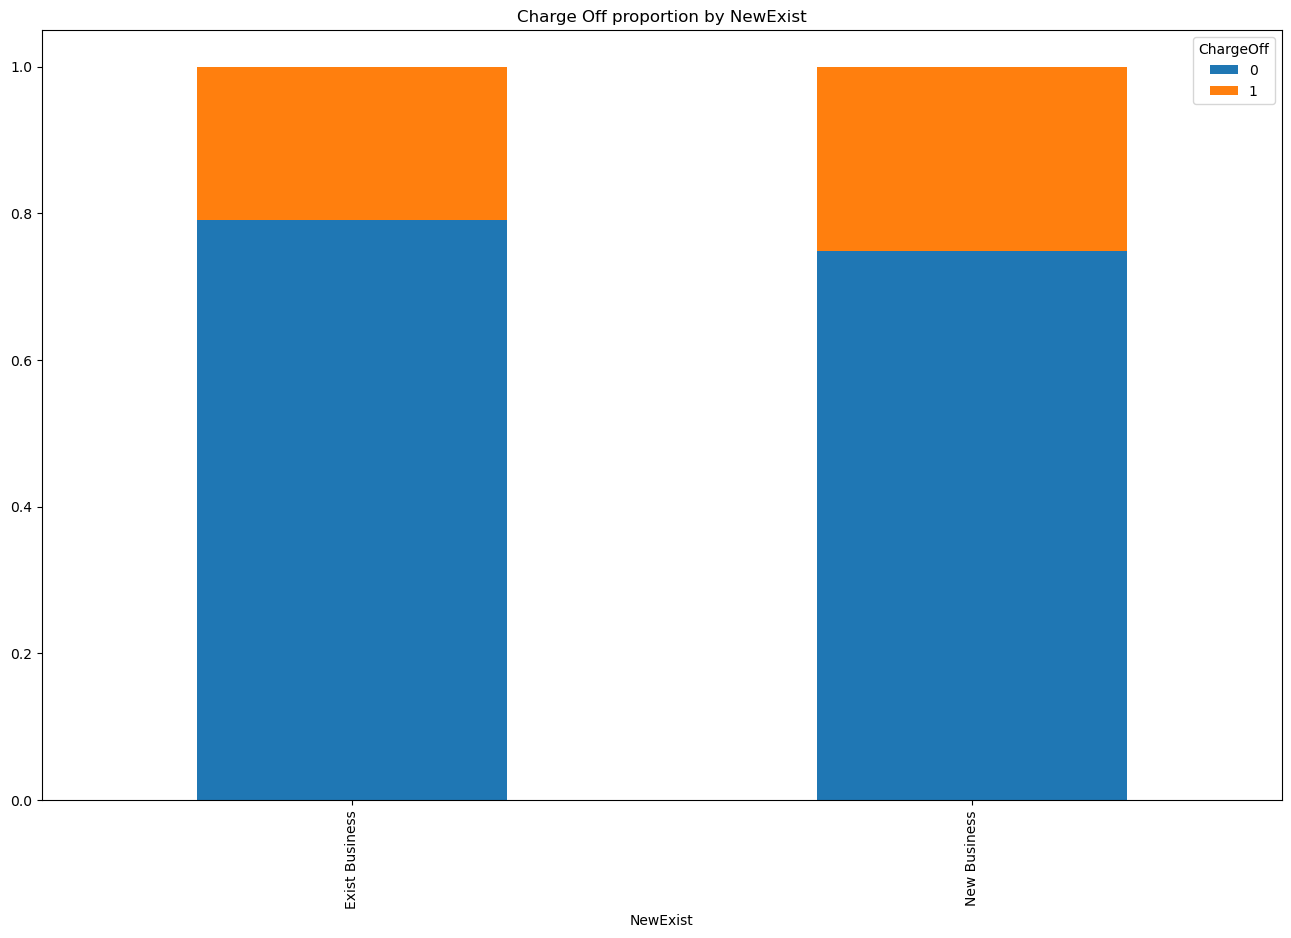

------------------------------------------------------------------------------


ChargeOff,0,1
UrbanRural,,
Rural,67.009751,32.990249
Undefined,95.367672,4.632328
Urban,67.082729,32.917271


Column UrbanRural has strong relationship with ChargeOff.


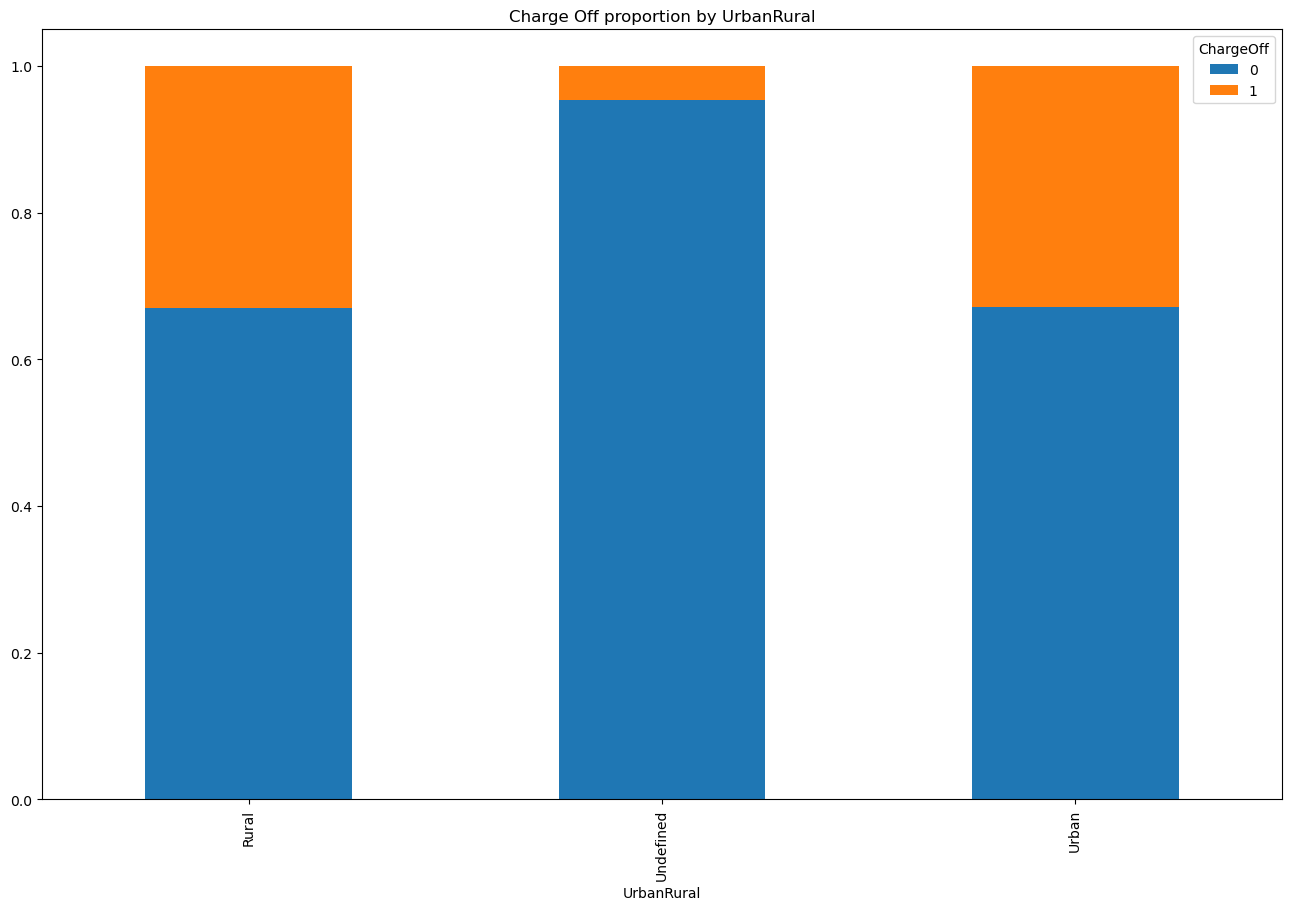

------------------------------------------------------------------------------


ChargeOff,0,1
RevLineCr,,
N,83.879059,16.120941
Y,69.035893,30.964107


Column RevLineCr has strong relationship with ChargeOff.


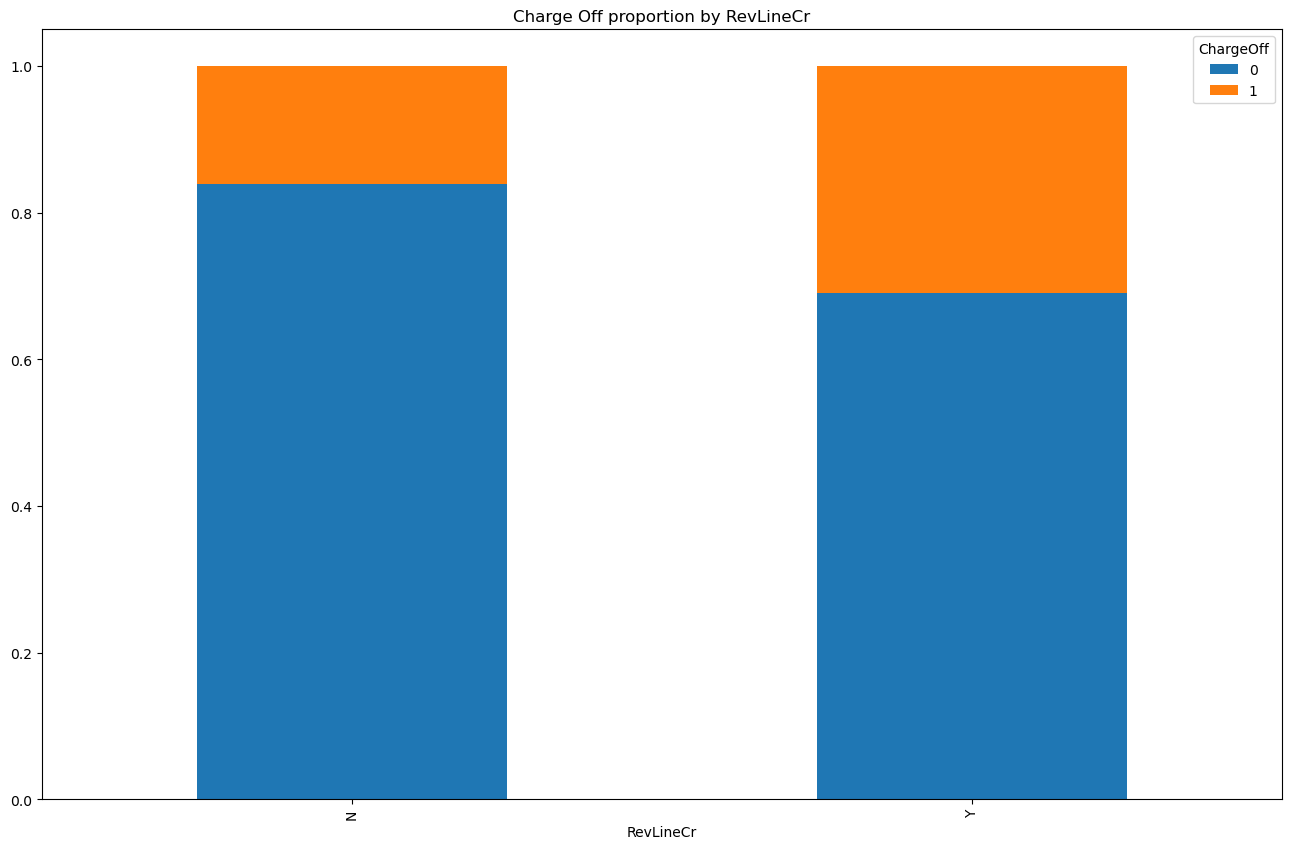

------------------------------------------------------------------------------


ChargeOff,0,1
LowDoc,,
N,77.755671,22.244329
Y,95.553453,4.446547


Column LowDoc has strong relationship with ChargeOff.


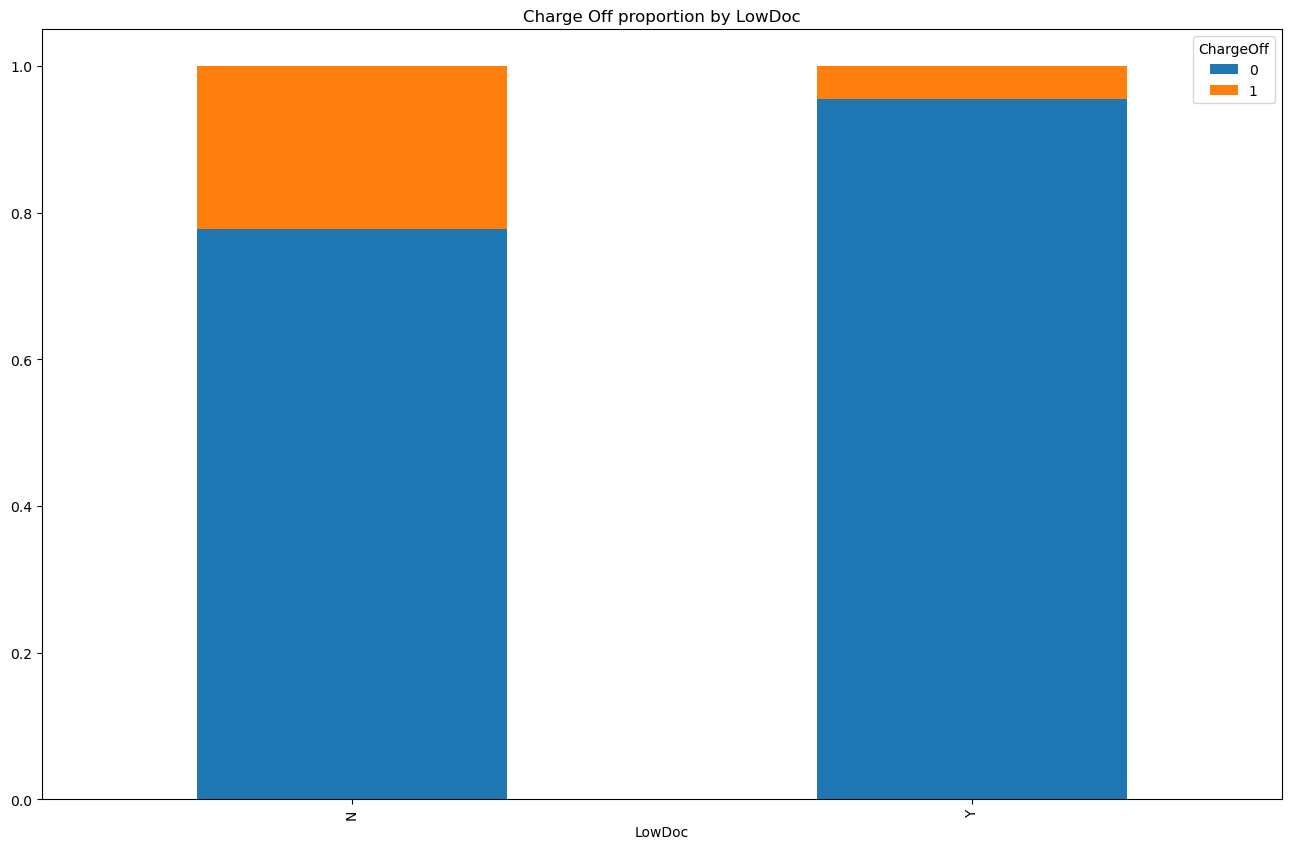

------------------------------------------------------------------------------


ChargeOff,0,1
ApprovalMonth,,
Apr,78.454874,21.545126
Aug,79.027232,20.972768
Dec,78.712871,21.287129
Feb,76.208113,23.791887
Jan,77.417208,22.582792
Jul,80.729027,19.270973
Jun,77.904607,22.095393
Mar,77.104936,22.895064
May,78.439656,21.560344


Column ApprovalMonth has strong relationship with ChargeOff.


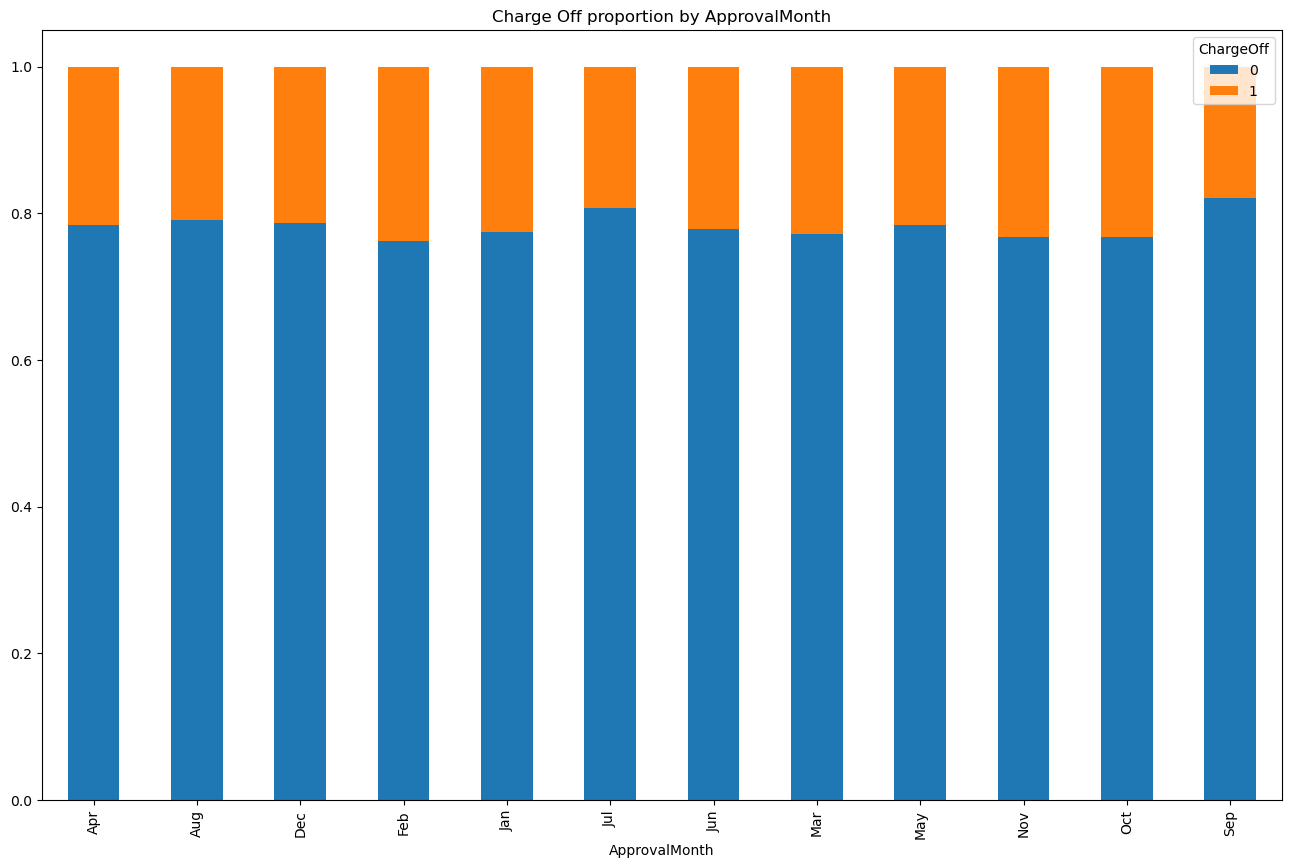

------------------------------------------------------------------------------


ChargeOff,0,1
Sector,,
Accommodation and Food Services,67.940604,32.059396
Administrative and Support and Waste Management and Remediation Services,64.477264,35.522736
"Agriculture, Forestry, Fishing and Hunting",91.129032,8.870968
"Arts, Entertainment, and Recreation",67.113402,32.886598
Construction,72.984864,27.015136
Educational Services,66.993464,33.006536
Finance and Insurance,60.553964,39.446036
Health Care and Social Assistance,87.016094,12.983906
Information,66.885246,33.114754


Column Sector has strong relationship with ChargeOff.


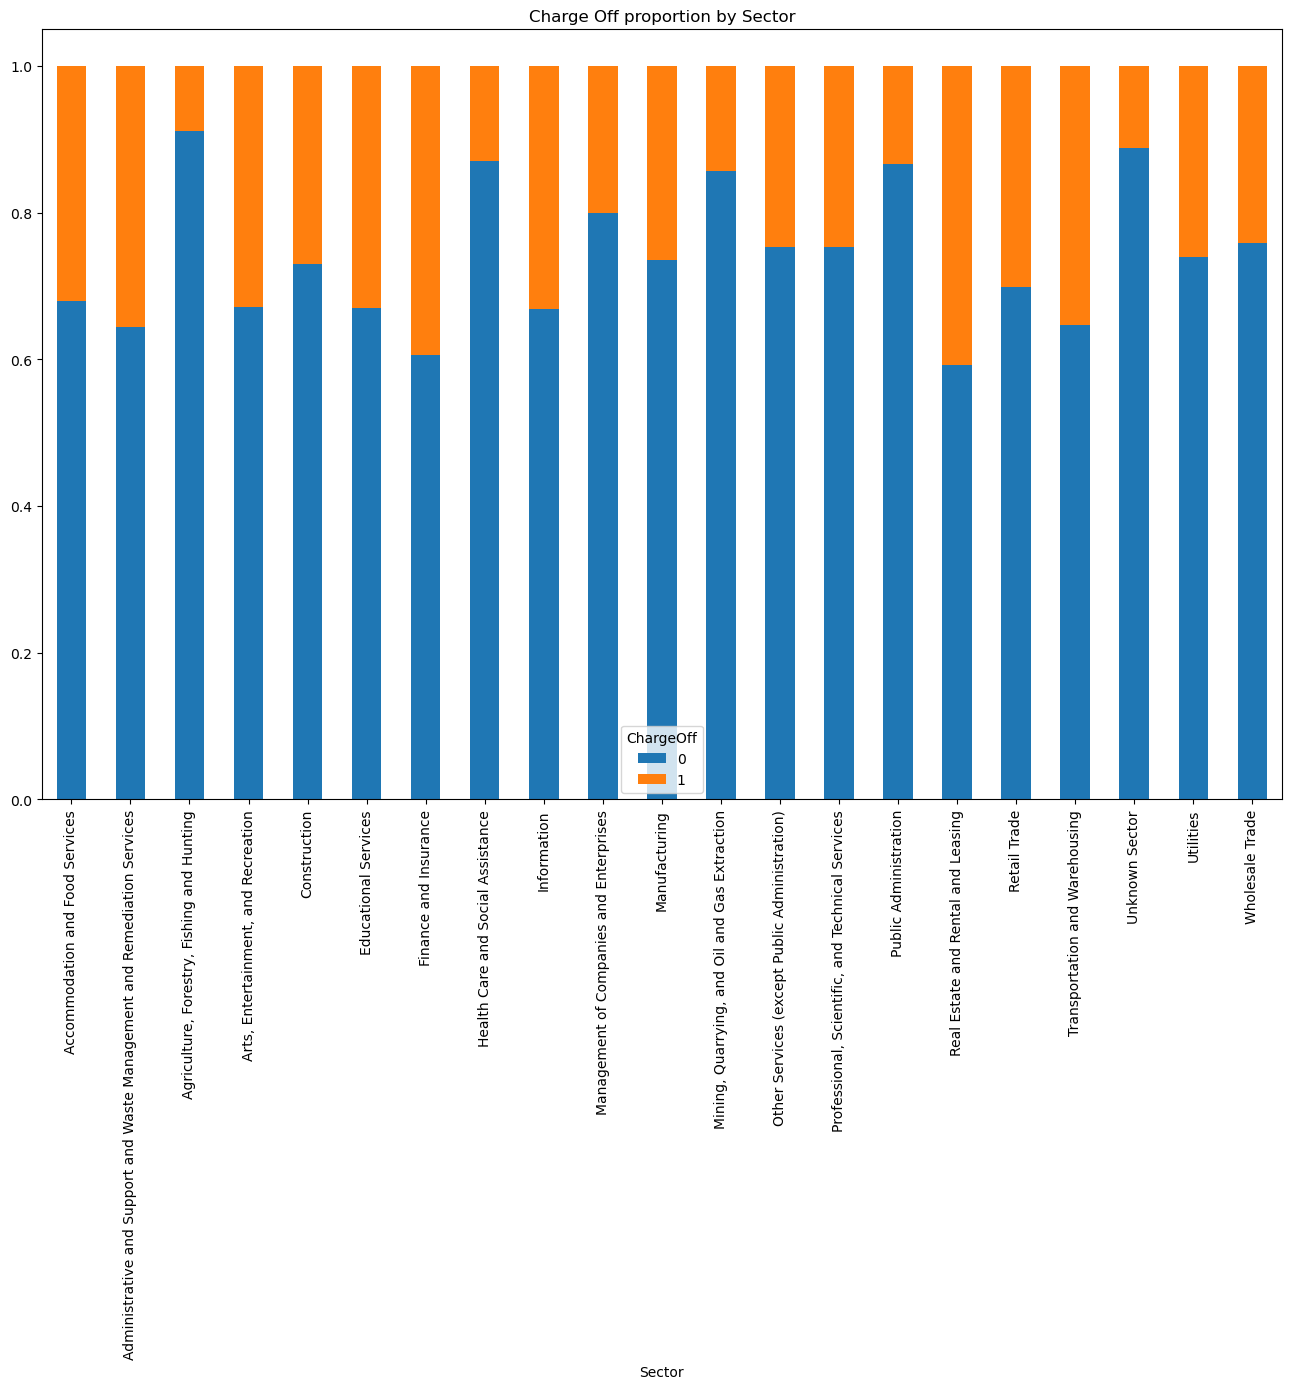

------------------------------------------------------------------------------


ChargeOff,0,1
NewBankState,,
AL,47.619048,52.380952
AZ,81.818182,18.181818
CA,86.298104,13.701896
CO,99.085923,0.914077
CT,65.789474,34.210526
DC,97.774481,2.225519
FL,54.961832,45.038168
HI,93.750000,6.250000
IL,51.107595,48.892405


Column NewBankState has strong relationship with ChargeOff.


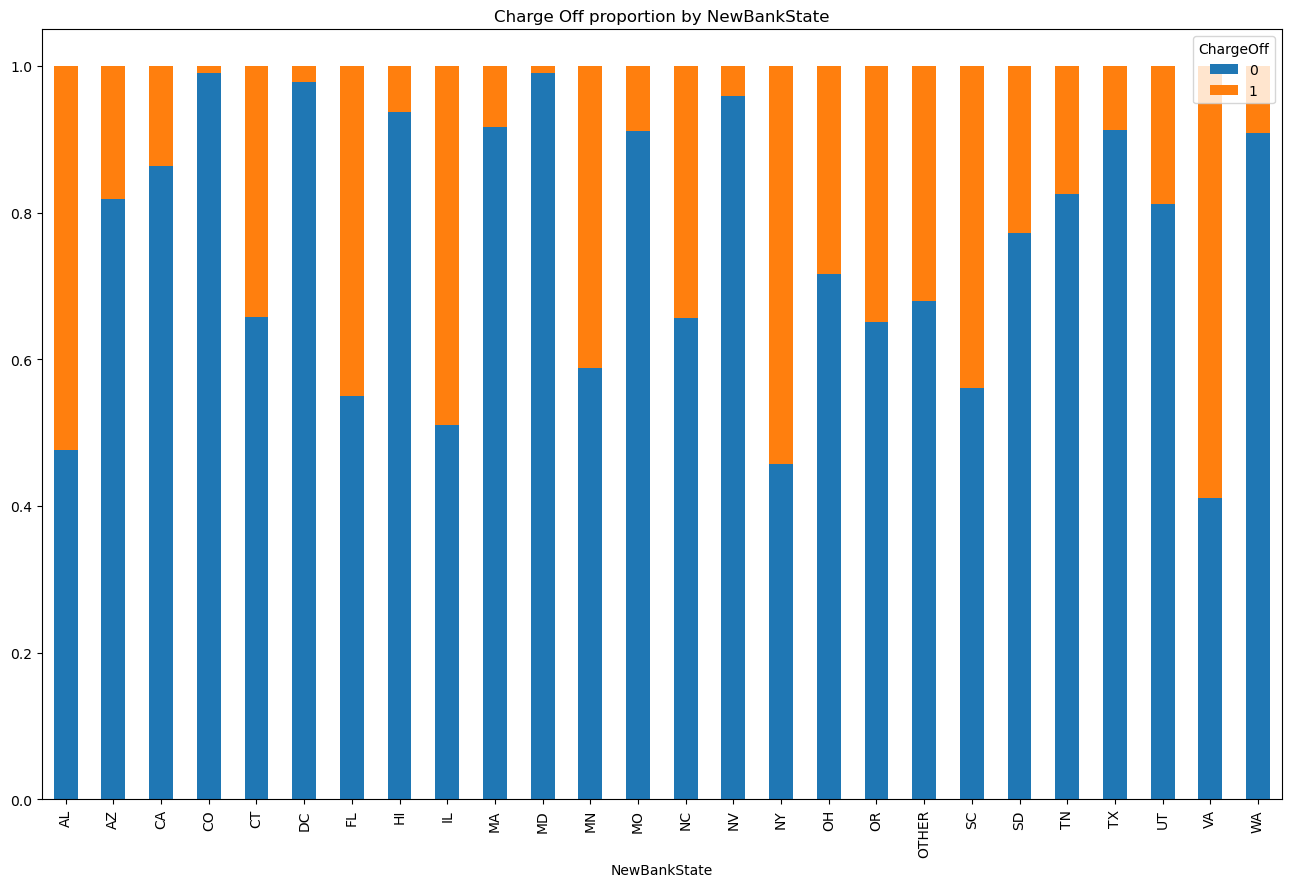

------------------------------------------------------------------------------


ChargeOff,0,1
IsFranchise,,
N,86.784551,13.215449
Y,78.224897,21.775103


Column IsFranchise has strong relationship with ChargeOff.


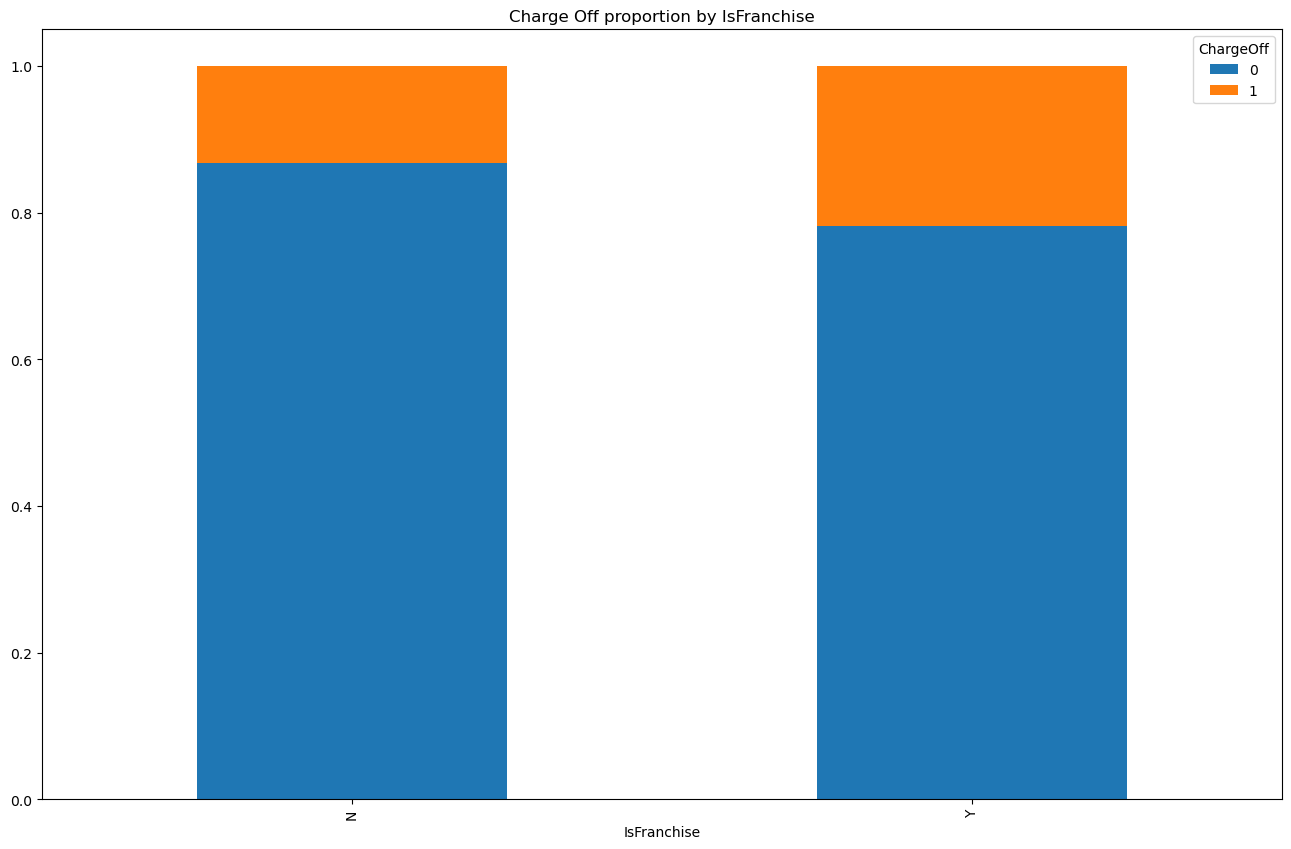

------------------------------------------------------------------------------


ChargeOff,0,1
NewCity,,
ALAMEDA,84.313725,15.686275
ALHAMBRA,85.093168,14.906832
ANAHEIM,81.716037,18.283963
ANTIOCH,68.148148,31.851852
ARCADIA,77.976190,22.023810
...,...,...
WHITTIER,69.194313,30.805687
WOODLAND,80.392157,19.607843
WOODLAND HILLS,71.162791,28.837209


Column NewCity has strong relationship with ChargeOff.


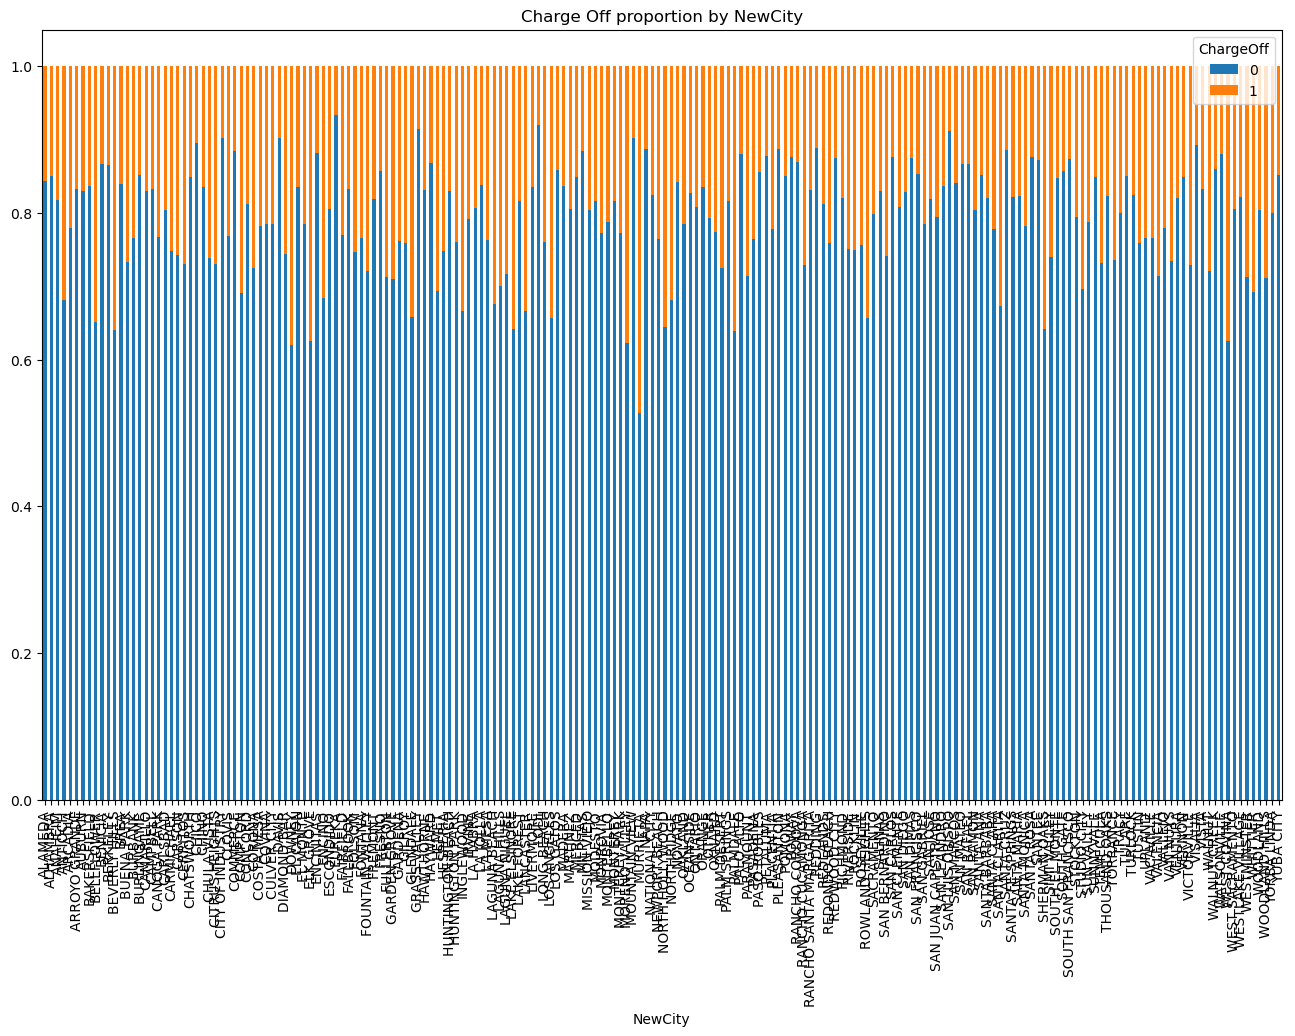

------------------------------------------------------------------------------


ChargeOff,0,1
NewBank,,
ADVANTAGE CERT. DEVEL CORP,100.000000,0.000000
AMERICAN RIVER BANK,96.376812,3.623188
AMERICANWEST BANK,89.361702,10.638298
BANC OF CALIFORNIA NATL ASSOC,91.869919,8.130081
BANCO POPULAR NORTH AMERICA,35.047219,64.952781
...,...,...
UNITI BANK,87.619048,12.380952
WELLS FARGO BANK NATL ASSOC,82.487982,17.512018
WESTAMERICA BANK,94.288793,5.711207


Column NewBank has strong relationship with ChargeOff.


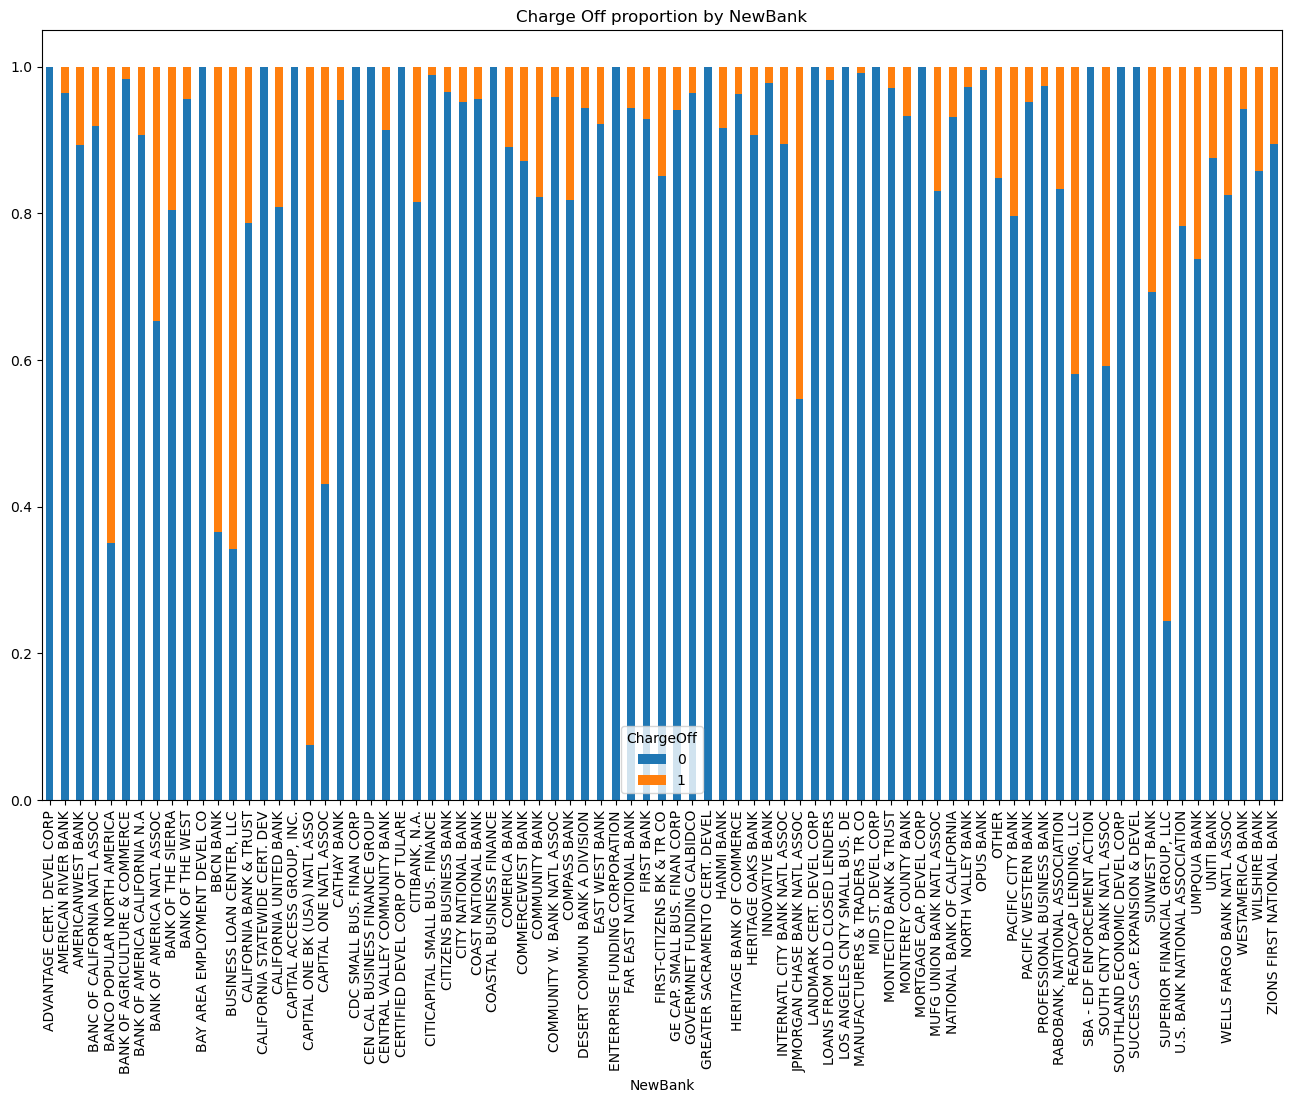

------------------------------------------------------------------------------


In [71]:
for col in sba_cat.columns:
    cat_vs_chgoff(col)

In [72]:
def num_vs_chgoff(column):
    data1 = sba_num[sba5['ChargeOff']==0][column]
    data2 = sba_num[sba5['ChargeOff']==1][column]
    
    stat, p = stats.ttest_ind(a=data1, b=data2, equal_var=True)
    if(p<0.05):
        print(f'Column {column} has strong relationship with MIS Status.')
    else:
        print(f'Column {column} has weak relationship with MIS Status.')

    plt.figure(figsize=(10,5))
    plt.title(f'{col} distribution Split by ChargeOff')
    sns.boxplot(data=sba5, y='ChargeOff', x=column)
    plt.legend()
    plt.show()
    print('------------------------------------------------------------------------------')

In [73]:
sba_num.head()

,Term,NoEmp,CreateJob,RetainedJob,ChargeOff
0,83,18,5,23,0
1,60,3,2,5,0
2,300,12,0,0,0
3,120,12,0,0,0
4,36,5,1,1,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Column Term has strong relationship with MIS Status.


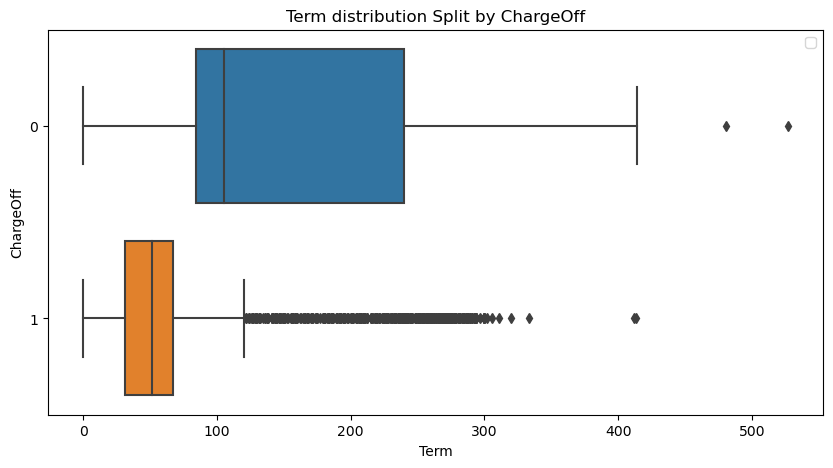

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------------------------------------------------
Column NoEmp has strong relationship with MIS Status.


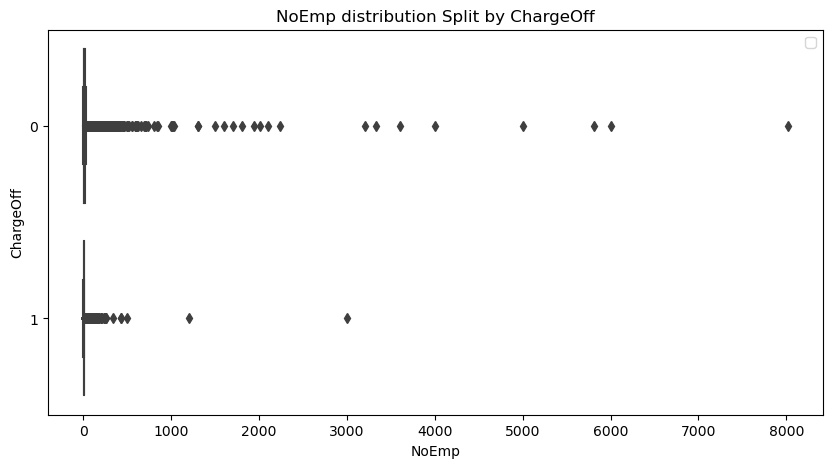

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------------------------------------------------
Column CreateJob has weak relationship with MIS Status.


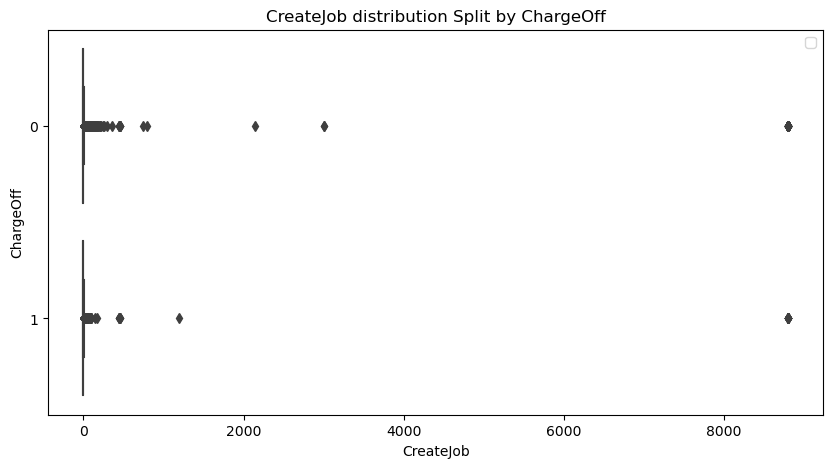

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------------------------------------------------
Column RetainedJob has weak relationship with MIS Status.


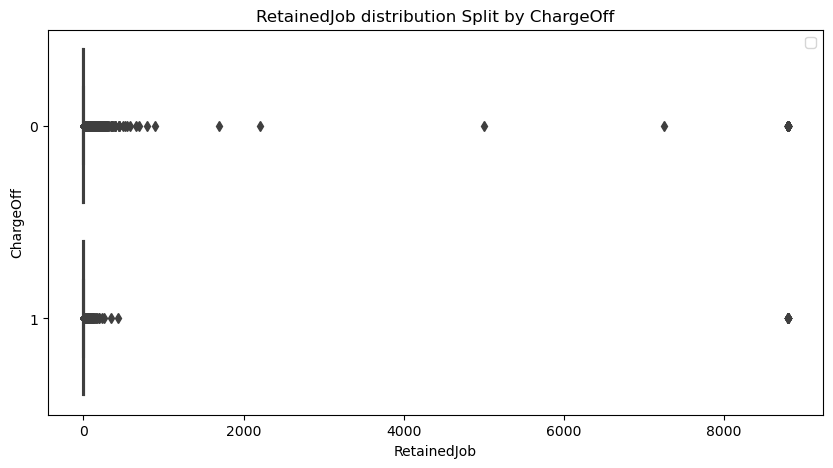

------------------------------------------------------------------------------


In [74]:
num_cols = list(sba_num.columns)
num_cols.remove('ChargeOff')
for col in num_cols:
    num_vs_chgoff(col)

## Correlation Between Independent Variables

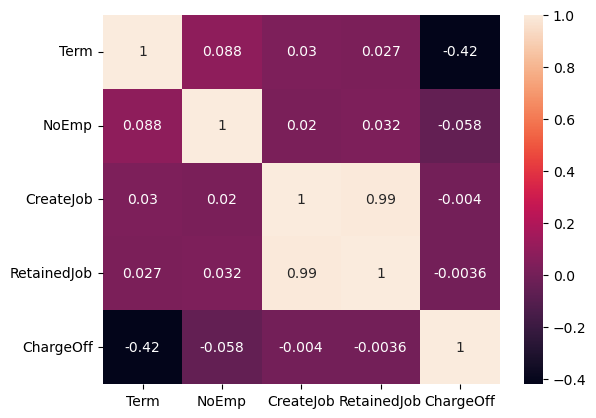

In [75]:
sns.heatmap(sba_num.corr(), annot=True)
plt.show()

## VIF (Multicolinearity Check)

In [76]:
vif_data = pd.DataFrame()
vif_data["feature"] = sba_num.drop('ChargeOff', axis=1).columns
vif_data["VIF"] = [vif(sba_num.drop('ChargeOff', axis=1).values, i)
                          for i in range(len(sba_num.drop('ChargeOff', axis=1).columns))]
vif_data

,feature,VIF
0,Term,1.053974
1,NoEmp,1.059927
2,CreateJob,46.309404
3,RetainedJob,46.368976


In [77]:
vif_data = pd.DataFrame()
vif_data["feature"] = sba_num.drop(['CreateJob', 'ChargeOff'], axis=1).columns
vif_data["VIF"] = [vif(sba_num.drop(['CreateJob', 'ChargeOff'], axis=1).values, i)
                          for i in range(len(sba_num.drop(['CreateJob', 'ChargeOff'], axis=1).columns))]
vif_data

,feature,VIF
0,Term,1.053569
1,NoEmp,1.052121
2,RetainedJob,1.004017


## Average ChargeOff

In [78]:
checking_diff = sba[sba['MIS_Status']=='CHGOFF'][['Name', 'ChgOffPrinGr', 'GrAppv']].dropna()
checking_diff.head()

,Name,ChgOffPrinGr,GrAppv
6,MIDDLE ATLANTIC SPORTS CO INC,"$208,959.00","$600,000.00"
36,PAUL E. & JUDY A. FAATZ,"$14,084.00","$47,000.00"
43,LARRY SCHOETTMER FORD INC,"$44,374.00","$200,000.00"
58,NEW DIMENSION HOMES INC,"$1,043,508.00","$1,350,000.00"
60,Mykols Marine Inc.,"$23,484.00","$25,000.00"


In [79]:
checking_diff['ChgOffPrinGr'] = checking_diff['ChgOffPrinGr'].str.replace('$','').str.replace(',','').astype('float')
checking_diff['GrAppv'] = checking_diff['GrAppv'].str.replace('$','').str.replace(',','').astype('float')

diff_by_name = checking_diff.groupby('Name').agg({'ChgOffPrinGr':'max', 'GrAppv':'sum'})
diff_by_name['Diff%'] = diff_by_name['ChgOffPrinGr']/diff_by_name['GrAppv']*100
diff_by_name.describe()

,ChgOffPrinGr,GrAppv,Diff%
count,1.460320e+05,1.460320e+05,146032.000000
mean,7.807575e+04,1.285093e+05,72.350052
std,1.424173e+05,2.655776e+05,26.472799
min,0.000000e+00,1.000000e+03,0.000000
25%,1.574075e+04,2.500000e+04,54.750531
50%,3.415700e+04,5.000000e+04,79.964400
75%,7.548225e+04,1.100000e+05,95.284000
max,3.512596e+06,2.782990e+07,897.920000


In [80]:
diff_by_name[diff_by_name['Diff%']>100]

,ChgOffPrinGr,GrAppv,Diff%
Name,,,
"5 J WELDING, INC.",41814.0,40000.0,104.535000
960 CONOCO,1039667.0,1000000.0,103.966700
A SHELLEY DESIGN,28628.0,24000.0,119.283333
"A TO Z WELDING & MFG.,INC.",746034.0,475000.0,157.059789
A&N TRADING INC.,42224.0,33700.0,125.293769
...,...,...,...
YOGIS CONOCO CHURCHS FRIED CHI,1002941.0,1000000.0,100.294100
"Yooter Interactive Marketing,",35889.0,35000.0,102.540000
ZAPATA CONTRACTORS INC,190809.0,150000.0,127.206000


In [81]:
print(f'Object columns: {len(sba5.select_dtypes(include="object").columns)}')
print(f'Numeric columns: {len(sba5.select_dtypes(exclude="object").columns)}')

Object columns: 10
Numeric columns: 5


In [82]:
sba5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81074 entries, 0 to 81073
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Term           81074 non-null  int64   
 1   NoEmp          81074 non-null  int64   
 2   NewExist       81074 non-null  object  
 3   CreateJob      81074 non-null  int64   
 4   RetainedJob    81074 non-null  int64   
 5   UrbanRural     81074 non-null  object  
 6   RevLineCr      81074 non-null  object  
 7   LowDoc         81074 non-null  object  
 8   ChargeOff      81074 non-null  category
 9   ApprovalMonth  81074 non-null  object  
 10  Sector         81074 non-null  object  
 11  NewBankState   81074 non-null  object  
 12  IsFranchise    81074 non-null  object  
 13  NewCity        81074 non-null  object  
 14  NewBank        81074 non-null  object  
dtypes: category(1), int64(4), object(10)
memory usage: 8.7+ MB


In [83]:
# We also delete ApprovalMonth column, because this column value appear AFTER the lender approve their Credit Proposal.
# One of our objectives is to predict whether the company is PIF or CHGOFF, BEFORE the lender approve it.
X = sba5.drop(columns=['ChargeOff', 'ApprovalMonth'])
y = sba5['ChargeOff']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, stratify=y, random_state=2023)

In [84]:
X_train_val.shape, X_test.shape

((60805, 13), (20269, 13))

## Logistic Regression Pipeline

In [1]:

from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE 
one_hot_cols = X.select_dtypes(include='object').columns
numeric_cols = X.select_dtypes(exclude='object').columns
logit = LogisticRegression(solver='liblinear', random_state=2023)
smote = SMOTE(random_state=2023)

logit_pipe_num = Pipeline([
    ('scaler', RobustScaler()),
])

# for all object columns
logit_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

# transforming all columns
logit_transformer = ColumnTransformer([
    ('pipe_num', logit_pipe_num, numeric_cols),
    ('pipe_cat', logit_pipe_cat, one_hot_cols)
])

# combine all pipeline
logit_pipe_combine = Pipeline([
    ('transformer', logit_transformer),
    ('rfe', RFE(logit)),
    ('resampling', smote),
    ('logit', logit)
])

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (E:\anaconda\Lib\site-packages\sklearn\utils\_param_validation.py)

In [1]:
#

!